In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [8]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            yield from ()

In [12]:
run = 20
filenames = sorted(fn for fn in set(iglob(f"/data/Test/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))
bg_period, bg_mod = 3, 0  # /Background_Period

integ = (
    from_sequence(filenames)
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod
integ

,tag,tof,is_bg
npartitions=108,,,
,int64,object,bool
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [14]:
with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

[########################################] | 100% Completed |  2min 14.9s


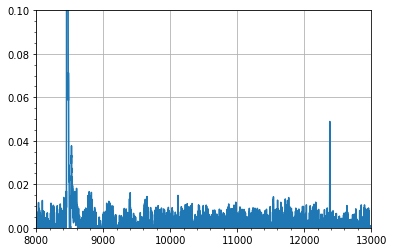

In [37]:
avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(8000, 13000)
plt.ylim(0, 0.1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [39]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[8000:9000].sum(),
                         'delay': round(dt, 2)}
                        for tag, iom, tof, dt
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01'
                                 '/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position']))
        except KeyError:
            yield from ()


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala)
        .flatten()
        .to_dataframe()
        .compute()
    )
df

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  2min 45.6s


,delay,img_intensity,tag
0,-6.05,441850,476675793
1,-6.05,441702,476675794
2,-6.05,441855,476675795
3,-6.05,442027,476675796
4,-6.05,441885,476675797
5,-6.05,441834,476675798
6,-6.05,442077,476675799
7,-6.05,441791,476675800
8,-6.05,441874,476675801
9,-6.05,441952,476675802


In [43]:
df['is_bg'] = df['tag'] % bg_period == bg_mod
groupped = df.groupby(['delay', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
groupped

count        sum
delay is_bg                  
-6.05 False   2000  883630694
      True    1000  441990229
-6.02 False   2000  883454716
      True    1000  441967237
-6.00 False   2000  883419558
      True    1000  441982108
-5.97 False   2000  883456219
      True    1000  441964406
-5.95 False   2000  883581327
      True    1000  441975790
-5.92 False   2000  883631714
      True    1000  441974197
-5.90 False   2000  883515650
      True    1000  441966028
-5.87 False   2000  883270079
      True    1000  441938278
-5.85 False   2000  883242163
      True    1000  441925949
-5.82 False   2000  883416067
      True    1000  441969448
-5.80 False   2000  883385069
      True    1000  441933055
-5.77 False   2000  883647025
      True    1000  441999410
-5.75 False   2000  883712278
      True    1000  441998814
-5.72 False   2000  883704791
      True    1000  441987715
-5.70 False   2000  883768006
      True    1000  441994734
-5.67 False   2000  883792688
      True    1000  441955450
-5.65 False   2000  883823643
      True    1000  441943075
-5.62 False   2000  883865903
      True    1000  441947771
-5.60 False   2000  883961625
      True    1000  441988974
-5.57 False   2000  883890433
      True    1000  441950117
-5.55 False   2000  883898531
      True    1000  441956680
-5.52 False   2000  883910874
      True    1000  441966746
-5.50 False   2000  884019178
      True    1000  442014057
-5.47 False   2000  884028330
      True    1000  442022861
-5.46 False      4    1767703
      True       2     884009
-5.45 False   1996  882193632
      True     998  441098019

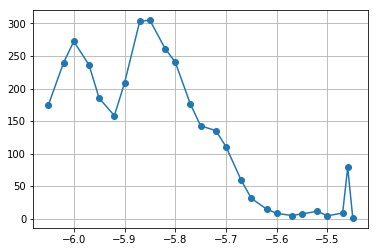

In [79]:
diff = -(
    (groupped.loc[pd.IndexSlice[:, False], 'sum'] / groupped.loc[pd.IndexSlice[:, False], 'count']).reset_index(level=1, drop=True)
    - (groupped.loc[pd.IndexSlice[:, True], 'sum'] / groupped.loc[pd.IndexSlice[:, True], 'count']).reset_index(level=1, drop=True)
)
plt.figure()
plt.plot(diff, 'o-')
plt.grid(True)
plt.show()